In [ ]:
!jupyter nbextension enable --py --sys-prefix widgetsnbextension
!pip install gmaps 
!jupyter nbextension enable --py --sys-prefix gmaps

In [33]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import requests
import json
import time
import os
import pprint
from census import Census
from us import states
import plotly
from scipy import interpolate
from config import(census_key,tamu_key )


c = Census(census_key , year=2017)


In [34]:
# read the bus stops csv file 
stops = os.path.join("..","Resources" ,"stops.csv")
stops_public = pd.read_csv(stops, header=0)
stops_public = stops_public.rename(columns= {"stop_lat": "lat","stop_lon":"lon"})
stops_public.head()

,stop_id,stop_code,stop_name,stop_desc,lat,lon,zone_id,stop_url,location_type,parent_station,stop_timezone,wheelchair_boarding,corner_placement,stop_position,on_street,at_street,heading
0,243,243,RIO GRANDE/15TH,000606 15Th & Rio Grande,30.278966,-97.746339,NaN,https://www.capmetro.org/stopdetail/index.php?...,0,NaN,NaN,0.0,NW,F,15Th,Rio Grande,288.0
1,466,466,8740 LAMAR/PAYTON GIN,008740 Lamar & Payton Gin,30.356809,-97.701066,NaN,https://www.capmetro.org/stopdetail/index.php?...,0,NaN,NaN,0.0,SW,M,Lamar,Payton Gin,227.0
2,467,467,FAIRFIELD STATION (SB),008630 Lamar & Fairfield,30.355296,-97.703128,NaN,https://www.capmetro.org/stopdetail/index.php?...,0,NaN,NaN,0.0,SW,F,Lamar,Fairfield,230.0
3,468,468,LAMAR/THURMOND,008400 Lamar & Thurmond,30.353139,-97.706082,NaN,https://www.capmetro.org/stopdetail/index.php?...,0,NaN,NaN,0.0,SW,F,Lamar,Thurmond,228.0
4,469,469,8320 LAMAR/MEADOWLARK,008320 Lamar & Meadowlark,30.352256,-97.707295,NaN,https://www.capmetro.org/stopdetail/index.php?...,0,NaN,NaN,0.0,NW,N,Lamar,Meadowlark,228.0


In [35]:
# tamu csv 
stops_zips = os.path.join("..","Resources" ,"bus_stop_zips.csv")
stops_zips_df = pd.read_csv(stops_zips, header=0)
stops_zips_df

,stop_id,stop_code,stop_name,lat,lon,Zip Codes
0,243,243,Rio Grande/15th,30.278966,-97.746339,78701
1,466,466,8740 Lamar/Payton Gin,30.356809,-97.701066,78753
2,467,467,Fairfield Station (SB),30.355296,-97.703128,78753
3,468,468,Lamar/Thurmond,30.353139,-97.706082,78753
4,469,469,8320 Lamar/Meadowlark,30.352256,-97.707295,78753
...,...,...,...,...,...,...
2406,6426,6426,Norwood Transit Center,30.340154,-97.691472,78753
2407,6427,6427,10099 Burnet/Mc Hale,30.385221,-97.723575,78758
2408,6428,6428,2007 Pleasant Valley/Riverside,30.233492,-97.724007,78741
2409,6430,6430,MLK Jr Station,30.279442,-97.709643,78702


# Texas A&M  Geocoding  Api

In [ ]:
#tamu_key = "…"
version = "4.10"
url= "https://geoservices.tamu.edu/Services/ReverseGeocoding/WebService/v04_01/HTTP/default.aspx"
zip_codes = []
for lat, lon in zip(stops_public['lat'], stops_public['lon']):
    payload = {
        "apiKey": tamu_key,
        "version": version,
        "format": "json",
        "lat": lat,
        "lon": lon}
    r = requests.get(url, params= payload).json()
    zip_codes.append(r)
zip_codes_two = []
for x in range(len(zip_codes)):
    zip_code_result = zip_codes[x]["StreetAddresses"][0]["Zip"]
    zip_codes_two.append(zip_code_result)
stops_public['Zip Codes'] = zip_codes_two
stops_public

# Census Api

In [36]:

#Run census search to retrieve data on all zip codes(2013 acs5 census)
census_data = c.acs5.get(("B01003_001E","B17001_002E"),
                         {'for': 'zip code tabulation area:*'})
#convert to datafame 
census_df = pd.DataFrame(census_data)

#Column Reordering 
census_df = census_df.rename(columns ={"B01003_001E":"Population",
                                       "B17001_002E":"Poverty_count",
                                       "zip code tabulation area":"Zip Codes"} )
#Add in poverty rate (povetry count /population )
census_df['Poverty_rate'] = census_df['Poverty_count'].astype(int)/census_df['Population'].astype(int) *100
census_df['Zip Codes'] = census_df['Zip Codes'].astype(str).astype(int)

#delete Povetry count 
del census_df['Poverty_count']


In [37]:

#clean up the zipcode df for null values, that might reduce the rows
census_df = census_df.dropna(axis=0)
print(len(census_df))
census_df.head()


32803


,Population,Zip Codes,Poverty_rate
0,17599.0,601,64.105915
1,39209.0,602,52.100283
2,50135.0,603,50.216416
3,6304.0,606,64.911168
4,27590.0,610,45.498369


In [39]:
#final dataFrame after Cleaning the data 
final_df = pd.merge(census_df, stops_zips_df, on = 'Zip Codes', how = 'inner')
final_df

,Population,Zip Codes,Poverty_rate,stop_id,stop_code,stop_name,lat,lon
0,77779.0,78613,3.783798,5698,5698,ACC Cypress Creek,30.479477,-97.834422
1,27900.0,78617,17.258065,3238,3238,Travis Correctional Facility,30.197840,-97.645546
2,27900.0,78617,17.258065,3240,3240,3103 SH 71/Cheviot,30.205035,-97.642589
3,27900.0,78617,17.258065,3241,3241,2777 SH 71/Golf Course,30.210895,-97.654067
4,27900.0,78617,17.258065,3323,3323,3320 FM 973/SH 71,30.200884,-97.640493
...,...,...,...,...,...,...,...,...
2406,41847.0,78759,5.348054,5755,5755,Braker/Mopac (Farside/Midblock),30.397553,-97.736066
2407,41847.0,78759,5.348054,5845,5845,Esperanza Crossing/Domain,30.399880,-97.724385
2408,41847.0,78759,5.348054,5916,5916,10001 Stonelake/Capital of Texas,30.391198,-97.739283
2409,41847.0,78759,5.348054,5920,5920,Mopac/Braker,30.393962,-97.732447


In [ ]:
##fisrt plot 

In [ ]:
census_data2 = c.acs5.get(("B01003_001E", "B17001_002E","B09001_001E","B08201_002E","B08301_018E","B08301_011E","B08301_019E","B08301_017E","B08301_021E","B08301_004E","B08301_003E","B08301_020E","B25001_001E"),
                        {'for':'zip code tabulation area:*'})
census_df2 = pd.DataFrame(census_data2)
census_df2 = census_df2.rename(columns={"B01003_001E":"Population",
                                       "B17001_002E": "Poverty Count",
                                       "zip code tabulation area":"Zip Codes",
                                       "B09001_001E":"Under 18 years",
                                       "B08201_002E":"HH with no vehicles",
                                       "B08301_018E": "Bike",
                                       "B08301_011E": "Bus",
                                       "B08301_019E": "Walk",
                                       "B08301_017E": "Motorcycle",
                                       "B08301_021E":"Telework",
                                       "B08301_004E":"Carpooled",
                                       "B08301_003E":"Drove alone",
                                       "B08301_020E":"Other",
                                       "B25001_001E":"Housing Unit"})
census_df2['Poverty Rate'] = census_df2['Poverty Count'].astype(int)/census_df2['Population'].astype(int) * 100
census_df2['% of Population Under 18'] = census_df2['Under 18 years'].astype(int)/census_df2['Population'].astype(int) * 100
census_df2['Zip Codes'] = census_df2['Zip Codes'].astype(str).astype(int)
del census_df2['Poverty Count']
del census_df2['Under 18 years']
census_df2 .head()

In [32]:
pov_stops_byzipcode = pd.merge(stops_zips_df,census_df2,on = 'Zip Codes', how = 'inner')
pov_stops_byzipcode.head()

,stop_id,stop_code,stop_name,lat,lon,Zip Codes,Population,HH with no vehicles,Bike,Bus,Walk,Motorcycle,Telework,Carpooled,Drove alone,Other,Housing Unit,Poverty Rate,% of Population Under 18
0,243,243,Rio Grande/15th,30.278966,-97.746339,78701,7875.0,450.0,215.0,85.0,832.0,5.0,947.0,107.0,3595.0,90.0,6576.0,13.180952,1.28254
1,501,501,Guadalupe/16th Street,30.278962,-97.742708,78701,7875.0,450.0,215.0,85.0,832.0,5.0,947.0,107.0,3595.0,90.0,6576.0,13.180952,1.28254
2,506,506,11th/Congress,30.272700,-97.741376,78701,7875.0,450.0,215.0,85.0,832.0,5.0,947.0,107.0,3595.0,90.0,6576.0,13.180952,1.28254
3,590,590,Lavaca/12th,30.274408,-97.742995,78701,7875.0,450.0,215.0,85.0,832.0,5.0,947.0,107.0,3595.0,90.0,6576.0,13.180952,1.28254
4,591,591,Capitol Station (NB),30.275587,-97.742558,78701,7875.0,450.0,215.0,85.0,832.0,5.0,947.0,107.0,3595.0,90.0,6576.0,13.180952,1.28254


In [ ]:
# second and third plot 

<Figure size 216000x72000 with 0 Axes>

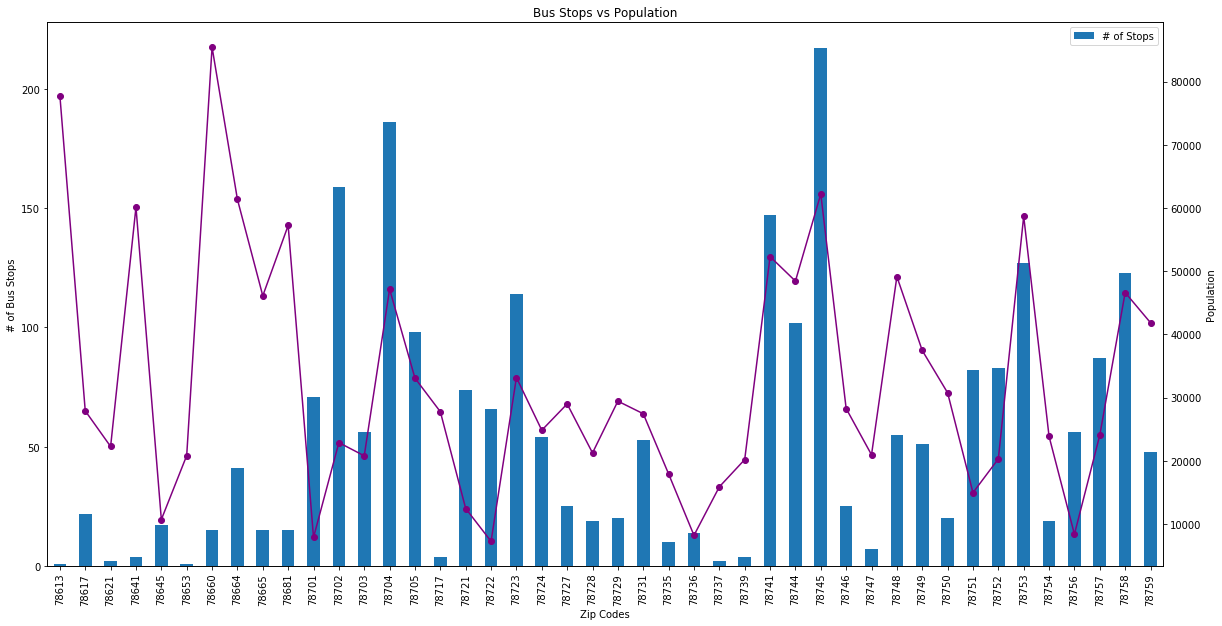

In [41]:
population= pov_stops_byzipcode.loc[:, ["Zip Codes", "Population"]].drop_duplicates()
bus_stop_count = pov_stops_byzipcode.groupby('Zip Codes').count()['stop_name']
stops_pop = pd.merge(bus_stop_count, population, on = ('Zip Codes','Zip Codes'), how = 'inner')
stops_pop.columns= ["Zip Codes","# of Stops","Population"]
stops_pop.set_index('Zip Codes', inplace=True)
plt.figure(figsize=(3000,1000))
ax = stops_pop[['# of Stops']].plot(kind='bar', use_index=True)
plt.ylabel('# of Bus Stops')
ax2 = ax.twinx()
plt.ylabel('Population')
ax2.plot(ax.get_xticks(),
    stops_pop[['Population']].values,
    color = 'purple',
    linestyle='-',
    marker='o', linewidth=1.5)
plt.title("Bus Stops vs Population")
plt.gcf().set_size_inches(20, 10)
plt.savefig("Bus Stops VS Population.png")
plt.show()
plt.close()


